In [ ]:
import sys
from pathlib import Path

import jupyter_compare_view
from jupyter_compare_view import compare
import ipywidgets as widgets

import argparse
import copy
from pathlib import Path
from typing import List
import numpy as np
import os
import matplotlib.pyplot as plt

#from scantools import logger
from scantools.capture import Capture, Trajectories, Proc, Pose
from scantools.utils.misc import add_bool_arg

from scantools.proc.rendering import Renderer
from scantools.utils.io import read_mesh, read_image
from scantools.viz.image import save_plot

: 

In [2]:
capture_path = "/media/HD18TB/armadillo/HYDRO_PL/capture/HYDRO"
query_id = "spot_2023-11-24-11-43" #"spot_2023-07-13-11-17"
ref_id = "2023-11-03_10.31.58+2023-11-03_13.51.06"
skip = 10

In [3]:
capture = Capture.load(capture_path)

[2025/05/16 14:43:32 scantools INFO] Loading Capture from /media/HD18TB/armadillo/HYDRO_PL/capture/HYDRO.


In [4]:
def read_raw_image(cam_id, data_path, images):
    if cam_id not in images:
        # It's a rig. Pick first camera.
        cam_id = list(sorted(images.keys()))[0]
    return read_image(data_path / images[cam_id])


def render_image(cam_id, T, images, cameras, renderer, rig=None):
    T = copy.deepcopy(T)
    if cam_id not in images:
        # It's a rig. Pick first camera.
        cam_id = list(sorted(images.keys()))[0]
        T_cam2rig = rig[cam_id]
        T = T * T_cam2rig
    camera = cameras[cam_id]
    render, _ = renderer.render_from_capture(T, camera)
    render = (np.clip(render, 0, 1) * 255).astype(np.uint8)
    return render

In [5]:
class ButtonHandler:
    def __init__(self, trajectory, session, data_path, renderer, skip=5):
        self.idx = 0
        self.render = False
        self.keys = list(sorted(trajectory.key_pairs()))
        self.trajectory = trajectory
        self.session = session
        self.data_path = data_path
        self.renderer = renderer
        self.skip = skip
        self.ts, self.cam_id = sorted(self.trajectory.key_pairs())[0]
        self.raw_img = read_raw_image(self.cam_id, capture.data_path(query_id), session_q.images[self.ts])
        self.render_img = render_image(self.cam_id, self.trajectory[self.ts, self.cam_id], self.session.images[self.ts], self.session.sensors, self.renderer, rig=(self.session.rigs[self.cam_id] if self.cam_id in self.session.rigs else None))
    
    # This function is called when bprev is clicked
    def previous(self, event):
        self.idx = (self.idx - self.skip + len(self.keys)) % len(self.keys)
        self.render = False
        ts, cam_id = self.keys[self.idx]
        self.raw_img = read_raw_image(cam_id, self.data_path, self.session.images[ts])
        self.render_img = render_image(cam_id, self.trajectory[ts, cam_id], self.session.images[ts], self.session.sensors, self.renderer, rig=(self.session.rigs[cam_id] if cam_id in self.session.rigs else None))
        
    # This function is called when bnext is clicked
    def next(self, event):
        self.idx = (self.idx + self.skip) % len(self.keys)
        self.render = False
        ts, cam_id = self.keys[self.idx]
        self.raw_img = read_raw_image(cam_id, self.data_path, self.session.images[ts])
        self.render_img = render_image(cam_id, self.trajectory[ts, cam_id], self.session.images[ts], self.session.sensors, self.renderer, rig=(self.session.rigs[cam_id] if cam_id in self.session.rigs else None))

In [6]:
session_ref = capture.sessions[ref_id]
T_mesh2global = session_ref.proc.alignment_global.get_abs_pose('pose_graph_optimized')
session_q = capture.sessions[query_id]

#logger.info('Generating interactive visualization diffs by rendering.')
mesh = read_mesh(capture.proc_path(ref_id) / session_ref.proc.meshes['mesh'])
renderer = Renderer(mesh)
trajectory = session_q.proc.alignment_trajectories
if T_mesh2global is not None:
    trajectory = T_mesh2global.inv * trajectory

callback = ButtonHandler(trajectory, session_q, capture.data_path(query_id), renderer, skip)

bnext = widgets.Button(description='Next')
bnext.on_click(callback.next)

bprev = widgets.Button(description='Prev')
bprev.on_click(callback.previous)

widgets.VBox([bnext, bprev])

[2025/05/16 14:45:40 scantools.utils.io INFO] Reading mesh /media/HD18TB/armadillo/HYDRO_PL/capture/HYDRO/sessions/2023-11-03_10.31.58+2023-11-03_13.51.06/proc/meshes/mesh.ply.


AttributeError: module 'raybender' has no attribute 'create_scene'


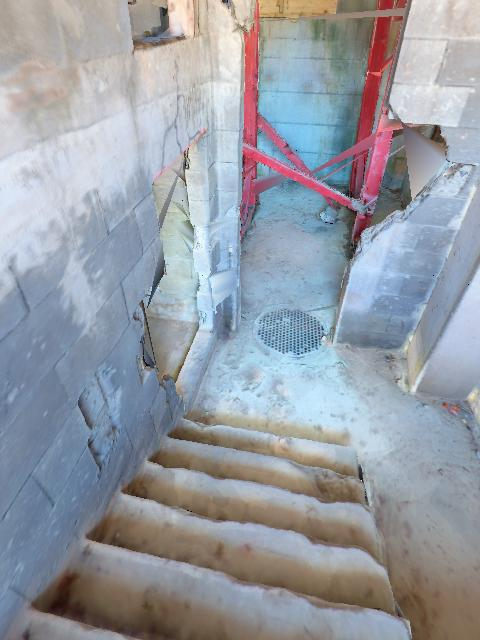
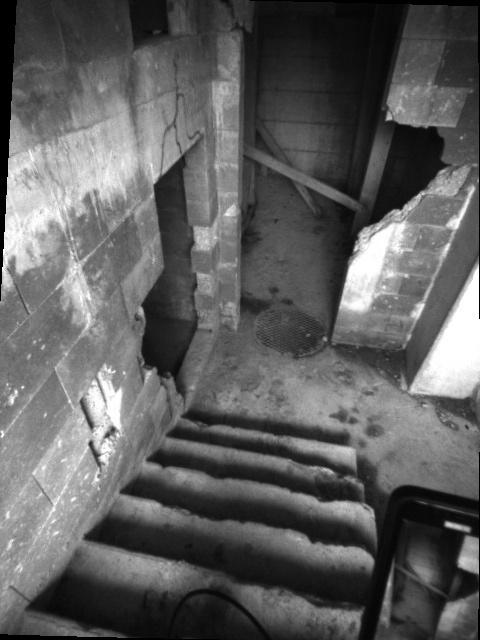

In [ ]:
compare(callback.render_img, callback.raw_img, cmap="gray", start_mode="horizontal", start_slider_pos=0.5)